读取上海市渣土车运行轨迹数据，原数据共 8 列，此处只读取分析需要的 4 列：车牌号、时间、经度、维度

In [1]:
import pandas as pd
import arctern
from arctern import GeoSeries

sh_columns=[
    ("plate_number","string"),
    ("pos_time","string"),
    ("pos_longitude","double"),
    ("pos_latitude","double"),
    ("pos_direction0","double"),
    ("pos_direction1","double"),
    ("pos_direction2","double"),
    ("pos_direction3","double")
]

sh_select_columns={
                   "plate_number",
                   "pos_time",
                   "pos_longitude",
                   "pos_latitude"
                  }

sh_schema={}
sh_use_cols=[]
sh_names=[]
for idx in range(len(sh_columns)):
    if sh_columns[idx][0] in sh_select_columns:
        sh_schema[sh_columns[idx][0]] = sh_columns[idx][1]
        sh_use_cols.append(idx)
        sh_names.append(sh_columns[idx][0])
            
sh_df = pd.read_csv("/tmp/20181016.txt",
                    usecols=sh_use_cols,
                    names=sh_names,
                    dtype=sh_schema,
                    header=None,
                    delimiter="\t",
                    date_parser=pd.to_datetime,
                    parse_dates=["pos_time"])

使用经纬度信息，构造位置点信息

In [2]:
sh_df["pos_point"]=GeoSeries.point(sh_df.pos_longitude,sh_df.pos_latitude)
sh_df

,plate_number,pos_time,pos_longitude,pos_latitude,pos_point
0,沪DK7362,2018-10-16 00:00:00,121.273108,30.989863,POINT (121.273108 30.989863)
1,沪DT0830,2018-10-16 00:00:00,121.471555,31.121763,POINT (121.471555 31.121763)
2,沪EP2723,2018-10-16 00:00:00,121.717205,31.380190,POINT (121.717205 31.38019)
3,沪DH9100,2018-10-16 00:00:00,121.476368,31.197768,POINT (121.476368 31.197768)
4,沪DP8608,2018-10-16 00:00:00,121.826568,31.096545,POINT (121.826568 31.096545)
...,...,...,...,...,...
2076589,沪EG9666,2018-10-16 23:59:31,121.753138,31.356040,POINT (121.753138 31.35604)
2076590,沪DP8746,2018-10-16 23:59:35,121.447145,31.125255,POINT (121.447145 31.125255)
2076591,沪DP8746,2018-10-16 23:59:41,121.448203,31.125408,POINT (121.448203 31.125408)
2076592,沪DP8746,2018-10-16 23:59:48,121.449426,31.125510,POINT (121.449426 31.12551)


选取其中一个车牌号，并筛选该车牌号的所有数据

In [3]:
one_trunck_plate_number=sh_df.plate_number[0]
print(one_trunck_plate_number)
one_truck_df = sh_df[sh_df.plate_number==one_trunck_plate_number]

沪DK7362


在地图上绘制这个车牌号的所有轨迹点

In [4]:
from keplergl import KeplerGl
KeplerGl(data={"car_pos": pd.DataFrame(data={'car_pos':one_truck_df.pos_point.to_wkt()})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'car_pos':                               car_pos
0        POINT (121.273108 30.989863)
4922    …

加载上海市的路网信息

In [5]:
sh_roads=pd.read_csv("/tmp/sh_roads.csv", 
                     dtype={"roads":"string"},
                     usecols=[0],
                     names=["roads"],
                     header=None,
                     delimiter='|')
sh_roads=GeoSeries(sh_roads.roads)
sh_roads

0        LINESTRING (121.6358731 31.221484,121.6359771 ...
1        LINESTRING (121.6362516 31.2205594,121.6360422...
2        LINESTRING (121.6372043 31.220911,121.6369344 ...
3        LINESTRING (121.4637777 31.2314411,121.4637564...
4        LINESTRING (121.4628334 31.2311683,121.4627892...
                               ...                        
74688    LINESTRING (121.2544395 31.0235354,121.2550238...
74689    LINESTRING (121.6372338 31.2208457,121.6362516...
74690    LINESTRING (121.6372338 31.2208457,121.6373315...
74691    LINESTRING (121.3657763 31.085248,121.3656812 ...
74692    LINESTRING (121.6372043 31.220911,121.6372338 ...
Name: roads, Length: 74693, dtype: GeoDtype

同时在地图上绘制前述轨迹点信息和路网信息

In [6]:
one_truck_roads=KeplerGl(data={"car_pos": pd.DataFrame(data={'car_pos':one_truck_df.pos_point.to_wkt()})})
one_truck_roads.add_data(data=pd.DataFrame(data={'sh_roads':sh_roads.to_wkt()}),name="sh_roads")
one_truck_roads

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'car_pos':                               car_pos
0        POINT (121.273108 30.989863)
4922    …

局部放大后可以发现有些轨迹点并不在路上

我们认为并不在路上的轨迹点为噪点信息，需要将轨迹点绑定到离它最近的一条道路上

In [7]:
is_near_road=arctern.near_road(sh_roads,sh_df.pos_point)
sh_near_road_df=sh_df[is_near_road]
on_road=arctern.nearest_location_on_road(sh_roads, sh_near_road_df.pos_point)
on_road=GeoSeries(on_road)
on_road

0          POINT (121.273065837839 30.9898629672054)
1          POINT (121.471521117758 31.1218966267949)
2          POINT (121.717183265368 31.3801593122801)
3           POINT (121.47636780833 31.1977688430427)
4          POINT (121.826533061028 31.0965194009541)
                             ...                    
2076589    POINT (121.753124012736 31.3560208068604)
2076590     POINT (121.44712530551 31.1255173541719)
2076591    POINT (121.448188797914 31.1255971887735)
2076592    POINT (121.449412558681 31.1256890544539)
2076593    POINT (121.880966206794 31.0821528456654)
Length: 1807018, dtype: GeoDtype

使用绑定到路上点，重新构造 `DataFrame`

In [8]:
sh_on_road_df=pd.DataFrame(data={"plate_number":sh_near_road_df.plate_number,
                                 "pos_time":sh_near_road_df.pos_time,
                                 "on_road":on_road
                                })
sh_on_road_df

,plate_number,pos_time,on_road
0,沪DK7362,2018-10-16 00:00:00,POINT (121.273065837839 30.9898629672054)
1,沪DT0830,2018-10-16 00:00:00,POINT (121.471521117758 31.1218966267949)
2,沪EP2723,2018-10-16 00:00:00,POINT (121.717183265368 31.3801593122801)
3,沪DH9100,2018-10-16 00:00:00,POINT (121.47636780833 31.1977688430427)
4,沪DP8608,2018-10-16 00:00:00,POINT (121.826533061028 31.0965194009541)
...,...,...,...
2076589,沪EG9666,2018-10-16 23:59:31,POINT (121.753124012736 31.3560208068604)
2076590,沪DP8746,2018-10-16 23:59:35,POINT (121.44712530551 31.1255173541719)
2076591,沪DP8746,2018-10-16 23:59:41,POINT (121.448188797914 31.1255971887735)
2076592,沪DP8746,2018-10-16 23:59:48,POINT (121.449412558681 31.1256890544539)


再次绘制前述车辆的轨迹点及上海市的路网信息

In [9]:
one_on_road_df=sh_on_road_df[sh_on_road_df.plate_number==one_trunck_plate_number]
one_on_roads=KeplerGl(data={"car_pos": pd.DataFrame(data={'car_pos':one_on_road_df.on_road.to_wkt()})})
one_on_roads.add_data(data=pd.DataFrame(data={'sh_roads':sh_roads.to_wkt()}),name="sh_roads")
one_on_roads

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'car_pos':                                            car_pos
0        POINT (121.273065837839 …

局部放大后，可以发现所有点均在道路上

## 分析

根据前述信息可知，上海市的道路网信息共 74693 条记录，单并不是所有道路都会被渣土车经过，以下筛选出所有渣土车经过的道路

In [10]:
all_roads=arctern.nearest_road(sh_roads,sh_on_road_df.on_road)
all_roads=GeoSeries(all_roads)
road_codes, road_uniques = pd.factorize(all_roads)

打印所有渣土车经过的道路数据，及所占整体道路的百分比

In [11]:
print(len(road_uniques))
print(len(road_uniques)*100.0/len(sh_roads))

16450
22.0234827895519


绘制所有渣土车经过的道路

In [12]:
KeplerGl(data={"all_roads": pd.DataFrame(data={'all_roads':GeoSeries(road_uniques).to_wkt()})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'all_roads':                                                all_roads
0      LINESTRING (121.27…

对于一些主干道路，每辆渣土车都可能会经过，导致这条道路上的`GPS`信号采样点比较多，同时因为是主干道路，进过车辆比较多，导致车辆速度缓慢，从而进一步加强该道路上的`GPS`采样点数据

一下统计每条道路上的`GPS`采样点数目，并重新构建`DataFrame`，我们把道路上`GPS`采样点的数据记为道路权重

In [13]:
roads_codes_series = pd.Series(road_codes)
roads_codes_series = roads_codes_series.value_counts()
roads_codes_series = roads_codes_series.sort_index()

sh_road_weight = pd.DataFrame(data={"on_road":GeoSeries(road_uniques),
                                    "weight_value":roads_codes_series
                                   })

sh_road_weight

,on_road,weight_value
0,"LINESTRING (121.2730666 30.9888831,121.2730596...",1646
1,"LINESTRING (121.4677565 31.1198416,121.4678423...",1579
2,"LINESTRING (121.7202751 31.3780202,121.7197339...",141
3,"LINESTRING (121.477849 31.1981056,121.4742212 ...",83
4,"LINESTRING (121.8374393 31.0816313,121.8345587...",1268
...,...,...
16445,"LINESTRING (121.4278848 31.2389835,121.4280869...",3
16446,"LINESTRING (121.431042 31.2403309,121.4307167 ...",1
16447,"LINESTRING (121.6378175 31.2374256,121.6373658...",1
16448,"LINESTRING (121.432118 31.2416392,121.4314564 ...",1


输出道道路权重的基本概况，可以发现大部分道路是不繁忙的，但是也存在特别繁忙的道路

In [14]:
sh_road_weight.weight_value.describe()

count    16450.000000
mean       109.849119
std        802.067993
min          1.000000
25%          2.000000
50%          5.000000
75%         22.000000
max      28144.000000
Name: weight_value, dtype: float64

将`weight_value`绘制成柱状图，可进一步佐证，大部分道路是不繁忙的，但是个别道路特别繁忙

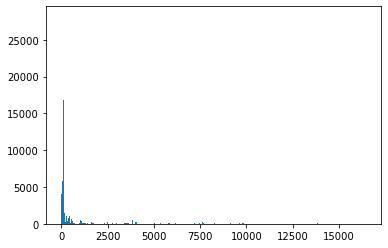

In [15]:
import matplotlib.pyplot as plt
plt.bar(sh_road_weight.index,sh_road_weight.weight_value)
plt.show()

按照道路权重，对所有道路做排序

In [16]:
sh_sorted_road=sh_road_weight.sort_values(by=['weight_value'],ascending=False)
sh_sorted_road

,on_road,weight_value
102,"LINESTRING (121.4248121 31.4032657,121.4265065...",28144
23,"LINESTRING (121.473513 31.3702961,121.4736103 ...",24364
9,"LINESTRING (121.6349225 31.14309,121.6348039 3...",21448
43,"LINESTRING (121.2749664 31.0244814,121.2722674...",20599
89,"LINESTRING (121.3814009 31.391344,121.3820681 ...",20463
...,...,...
13661,"LINESTRING (121.3757469 31.0789625,121.3756868...",1
7980,"LINESTRING (121.3675949 31.2531523,121.3677313...",1
11360,"LINESTRING (121.6867871 31.104265,121.6815152 ...",1
13664,"LINESTRING (121.5174295 31.2760579,121.5171332...",1


选取最繁忙的前100个路段

In [17]:
sh_sorted_road.iloc[0:100]

,on_road,weight_value
102,"LINESTRING (121.4248121 31.4032657,121.4265065...",28144
23,"LINESTRING (121.473513 31.3702961,121.4736103 ...",24364
9,"LINESTRING (121.6349225 31.14309,121.6348039 3...",21448
43,"LINESTRING (121.2749664 31.0244814,121.2722674...",20599
89,"LINESTRING (121.3814009 31.391344,121.3820681 ...",20463
...,...,...
13,"LINESTRING (121.4986731 31.2685444,121.4963124...",3668
566,"LINESTRING (121.3656233 31.257495,121.3689789 ...",3655
291,"LINESTRING (121.5675539 31.3573854,121.5650207...",3625
759,"LINESTRING (121.4644001 31.3612873,121.463751 ...",3622


在地图上绘制最繁忙的前100个路段

In [18]:
KeplerGl(data={"on_roads": pd.DataFrame(data={'on_roads':sh_sorted_road.on_road.iloc[0:100].to_wkt()})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'on_roads':                                               on_roads
102  LINESTRING (121.4248121…